In [15]:
import numpy as np
import random
from scipy import ndimage
from scipy.ndimage import label
import matplotlib.pyplot as plt
import string

In [16]:
## CHECK WHETHER THE INSECT IS VALID
def insectCheck(insect ,checkValues ,aspectRatio):
    # adding a boundary outside the insect
    borderSide = np.zeros((aspectRatio ,1))
    borderTop = np.zeros(2*aspectRatio + 3)
    insect = np.concatenate((np.concatenate((borderSide,insect),axis = 1),borderSide),axis = 1)
    insect = np.vstack((np.vstack((borderTop ,insect)),borderTop))
    # check for empty spaces inside body
    _, featureNo = label(insect)
    # check for empty spaces inside body
    _, negFeatureNo = label(1 - insect)
    
    return featureNo == checkValues [0] and negFeatureNo == checkValues [1]

In [17]:
## ESTABLISHING THE FUNCTION FOR GENERATING A RANDOM WING

def insectGeneration(aspectRatio,wingType):
        result = False
        checkValues = np.array([1,1])
        if wingType == 'random':
                nWing = int(random.uniform(0, aspectRatio * aspectRatio))
        else:
                nWing = wingType

        while result == False:

                body = np.ones((aspectRatio,1))

                # Create a binary matrix with all zeros
                wing = np.zeros((aspectRatio, aspectRatio), dtype=int)

                # Set a specific number of random positions to 1
                positions = np.random.choice(aspectRatio**2, nWing, replace=False)
                wing.flat[positions] = 1

                # wing = np.random.choice([0, 1], size=(aspectRatio, aspectRatio))
                insect = np.concatenate((np.concatenate((wing,body),axis = 1),np.fliplr(wing)),axis = 1)

                result = insectCheck(insect,checkValues,aspectRatio)
                #print(result)

        return np.array(insect)

(-0.5, 10.5, 4.5, -0.5)

<Figure size 640x480 with 0 Axes>

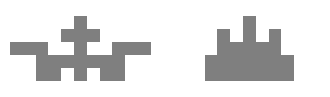

In [18]:
# GENERATING PARENTS WITH SAME NUMBER OF WING ELEMENTS AND PLOT PROBABILITY MAP
size = 9 # area of wing
aspectRatio = 5 # aspect ratio of body
conversion = 1  # conversion of grid - here 1x1 mm^2

parent1 = insectGeneration(aspectRatio,wingType = size)
parent2 = insectGeneration(aspectRatio,wingType = size)

body = np.ones((aspectRatio,1)) # pre-defined insect body


fig = plt.figure()
plt.figure(figsize=(4, 1))
plt.subplot(1,2,1)
plt.imshow(parent1, cmap='binary', interpolation='nearest', vmin=0, vmax=2) # locals()[f'parent{m}']
plt.xlim([-15,15])
plt.axis('equal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(parent2, cmap='binary', interpolation='nearest', vmin=0, vmax=2) # locals()[f'parent{m}']
plt.xlim([-15,15])
plt.axis('equal')
plt.axis('off')


In [19]:
## SAVING AS A MATRIX - EXAMPLE

# generating filename
letters = 5 # number of random letters in a string
shpName = ''.join(random.choice(string.ascii_letters) for _ in range(letters))
blockNo = int(np.sum(parent1))

filename = f'{shpName}_AR{aspectRatio}conv{conversion}_No{blockNo}'
folder = 'shapeFiles'
print(f'{folder}/{filename}')
np.save(f'{folder}/{filename}', parent1)

shapeFiles/wwBka_AR5conv1_No23


In [20]:
## GENERATING A DAUGHTER BASED ON THE PROBABILITY MAP
def daughterGen_prob(parent1 ,parent2 ,wingsize ,aspectRatio):
    result = False

    checkValues = np.array([1,1])
    body = np.ones((aspectRatio ,1))
    # order:
    # calculate the parent wing probability map
    # keep all the elements where the value is 1 (overlap between parents)
    # determine all indices where the value is 0.5 (i.e. one parent has a wing element present)
    # pick n random indices with a present wing element in a parent and fill them with ones, where n is the number of desired elements minus the number of existing ones # create final insect
    # check that the insect is valid
    # calculate parent wing probability map
    probability = (parent1 + parent2)/2
    probWing = np.copy(probability[:,0:aspectRatio])
    while result == False:

        # keep all the elements where the value is 1 (overlap between parents)
        wing = np.where(probWing < 1, 0, probWing)

        # determine all indices where the value is 0.5 (i.e. one parent has a wing element present)
        idx05 = np.argwhere(probWing == 0.5)

        # pick n random indices with a present wing element in a parent and fill them with ones, where n is the number of desired elements minus the number of existing ones
        n = int(wingsize - np.sum(wing))
        idxs = random.sample(range(len(idx05)), n)
        wing[tuple(idx05[idxs].T)] = 1
        
        # create the final insect
        insect = np.concatenate((np.concatenate((wing,body),axis = 1),np.fliplr(wing)),axis = 1)
        # check validity
        result = insectCheck(insect ,checkValues ,aspectRatio)
    return insect

In [21]:
## GENERATING A MUTATION THAT SWAPS OUT ONE ELEMENT AND PLACES IT IN AN EMPTY ELEMENT
def mutateDaughter(daughter ,aspectRatio):

    result = False
    checkValues = np.array([1,1])
    body = np.ones((aspectRatio ,1))

    # order:
    # extract the daughter wing
    # determine all indices where the value is 1 and 0
    # choose one randome index in both sets and switch the value # create final insect
    # check that the insect is valid

    while result == False:

        # extract the daughter wing
        wing = np.copy(daughter[:,0:aspectRatio])

        # determine all indices where the value is 1 and 0
        idx0 = np.argwhere(wing == 0)
        idx1 = np.argwhere(wing == 1)

        # choose one randome index in both sets and switch the value
        idx0s = random.sample(range(len(idx0)), 1)
        wing[tuple(idx0[idx0s].T)] = 1
        idx1s = random.sample(range(len(idx1)), 1)
        wing[tuple(idx1[idx1s].T)] = 0

        # create final insect
        insect = np.concatenate((np.concatenate((wing,body),axis = 1),np.fliplr(wing)),axis = 1)

        # check validity
        result = insectCheck(insect ,checkValues ,aspectRatio)
    return insect

In [22]:
## FUNCTION THAT ENCOMPASSES ALL FUNCTIONS
def daughterGen(parent1 ,parent2 ,aspectRatio ,wingsize ,mutateProbability):

    insect = daughterGen_prob(parent1 ,parent2 ,wingsize ,aspectRatio)
    
    # Mutate wing with the probability given
    if random.random() < mutateProbability:
        #print(’Daughter is mutated’)
        insect = mutateDaughter(insect ,aspectRatio)
    return insect

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]
 [0.  0.  1.  1.  1. ]
 [0.  0.  1.  1.  0.5]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]]


(-0.5, 10.5, 4.5, -0.5)

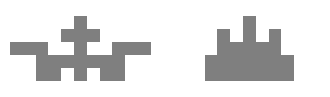

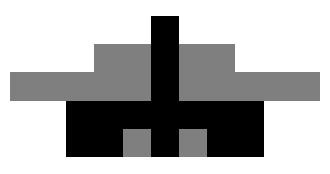

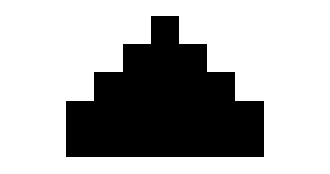

In [30]:
## GENERATING A PROBABILITY MAP FROM THE TWO PARENTS

probability = (parent1 + parent2)/2
probWing = np.copy(probability[:,0:aspectRatio])
print(probWing)

daughter = daughterGen(parent1,parent2,aspectRatio,wingsize = 9,mutateProbability = 0.2)
print(daughter)

plt.figure(figsize=(4, 1))
plt.subplot(1,2,1)
plt.imshow(parent1, cmap='binary', interpolation='nearest', vmin=0, vmax=2) # locals()[f'parent{m}']
plt.xlim([-15,15])
plt.axis('equal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(parent2, cmap='binary', interpolation='nearest', vmin=0, vmax=2) # locals()[f'parent{m}']
plt.xlim([-15,15])
plt.axis('equal')
plt.axis('off')

plt.figure(figsize=(4, 2))
plt.imshow(probability, cmap='binary', interpolation='nearest', vmin=0, vmax=1) # locals()[f'parent{m}']
plt.xlim([-15,15])
plt.axis('equal')
plt.axis('off')

plt.figure(figsize=(4, 2))
plt.imshow(daughter, cmap='binary', interpolation='nearest', vmin=0, vmax=1) # locals()[f'parent{m}']
plt.xlim([-15,15])
plt.axis('equal')
plt.axis('off')